In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [3]:
path = 'data/'
!ls data

application_test.csv	     HomeCredit_columns_description.csv
application_test.csv.zip     installments_payments.csv
application_train.csv	     installments_payments.csv.zip
application_train.csv.zip    POS_CASH_balance.csv
bureau_balance.csv	     POS_CASH_balance.csv.zip
bureau_balance.csv.zip	     previous_application.csv
bureau.csv		     previous_application.csv.zip
bureau.csv.zip		     sample_submission.csv
credit_card_balance.csv      sample_submission.csv.zip
credit_card_balance.csv.zip  subm
df_pref			     tmp


# View data

In [4]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [5]:
def display_allRows(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 10):
            display(df)

In [60]:
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')

In [61]:
bureau = pd.read_csv(path + 'bureau.csv')

In [67]:
application_train = pd.read_csv(path + 'application_train.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
bureau = pd.read_csv(path + 'bureau.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
pos_cash_balance = pd.read_csv(path+'POS_CASH_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')

# Feature Engineering

Code from https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [69]:
data = application_train
data.shape

(307511, 122)

In [70]:
#Function to encode and aggregate categorical values
def agg_cat(df, group_var, df_name):
    column_names = []
    du = pd.get_dummies(df.select_dtypes('object')) #one hot encoding
    du[group_var] = df[group_var] #putting identifying id back in
    cat = du.groupby(group_var).agg(['count','mean']) #count and average all features
    for i in cat.columns.levels[0]:
        column_names.append(df_name+'_'+i+'_sum');
        column_names.append(df_name+'_'+i+'_mean');
    
    cat.columns = column_names;
    return cat
    

In [71]:
#Function to aggregate numeric values in data set, plus counts repeat ids
def agg_num(df,group_var,df_name):
    column_names = []
    num = df.groupby(group_var).agg(['sum','min','max','mean'])
    for i in num.columns.levels[0]:
        for j in ['sum','min','max','mean']:
            column_names.append(df_name+'_'+i+'_'+j)
        
    num.columns = column_names
    count_column = pd.DataFrame(df.groupby(group_var).count().max(1)).rename(columns={0:df_name+'_count'})
    #count_column.rename(columns = {df.columns[1]:df_name+'_count'},inplace=True)
    num = num.merge(count_column, how='left', on=group_var)
    return num

In [63]:
#Bureau balance

#Aggregate categorical and numeric values
bur_bal_cat = agg_cat(bureau_balance,'SK_ID_BUREAU','bureau_bal')
bur_bal_num = agg_num(bureau_balance,'SK_ID_BUREAU','bureau_bal')

#Merge into one
bureau_bal_data = bur_bal_cat.merge(right=bur_bal_num.reset_index(),how='left', on ='SK_ID_BUREAU')

bureau.shape, bur_bal_cat.shape, bur_bal_num.shape, bureau_bal_data.shape

((1716428, 17), (817395, 16), (817395, 5), (817395, 22))

In [64]:
#Save data
data.to_feather('tmp/data_bureau_balance')

In [72]:
#Bureau data

prev_data = data #record for reference

#Aggregate categorical and numeric values
%time bureau_cat = agg_cat(bureau, 'SK_ID_CURR', 'bureau')
%time bureau_num = agg_num(bureau, 'SK_ID_CURR', 'bureau')

#Merge into data
%time data = data.merge(right=bureau_cat.reset_index(), how='left', on='SK_ID_CURR')
%time data = data.merge(right=bureau_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_bureau')

#print out size to check
prev_data.shape, bureau_cat.shape, bureau_num.shape,  bureau_bal_data.shape, data.shape

CPU times: user 2.38 s, sys: 184 ms, total: 2.56 s
Wall time: 2.56 s


KeyboardInterrupt: 

CPU times: user 1.73 s, sys: 1.26 s, total: 2.99 s
Wall time: 2.99 s
CPU times: user 572 ms, sys: 424 ms, total: 996 ms
Wall time: 997 ms


((307511, 122), (305811, 46), (305811, 53), (817395, 22), (307511, 221))

In [53]:
#Merge bureau balance data into data
data = data.merge(right=bureau_bal_data.reset_index(),how='left', on='SK_ID_BUREAU')

KeyError: 'SK_ID_BUREAU'

In [18]:
#Previous applications

prev_data = data #record for reference

#Count previous application
prev_apps_cat = agg_cat(previous_application,'SK_ID_CURR','prev_apps')
prev_apps_num = agg_num(previous_application,'SK_ID_CURR','prev_apps')

#Merge into data
data = data.merge(right=prev_apps_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=prev_apps_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_prev_apps')

#print out size to check
prev_data.shape, prev_apps_cat.shape, prev_apps_num.shape, data.shape

((1000, 193), (985, 230), (985, 81), (1000, 504))

In [19]:
#Installments Payments

## Average values for all other variables in installments payments
#avg_inst_cat = agg_cat(installments_payments,'SK_ID_CURR','avg_inst') #no categorical values
avg_inst_num = agg_num(installments_payments,'SK_ID_CURR','avg_inst')

#Merge into data
#data = data.merge(right=avg_inst_cat.reset_index(), how='left', on='SK_ID_CURR') #no categorical values
data = data.merge(right=avg_inst_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_avg_inst')

avg_inst_num.shape, data.shape

((965, 29), (1000, 533))

In [21]:
#Pos cash balance

### count the number of pos cash for a given ID
pcb_cat = agg_cat(pos_cash_balance,'SK_ID_CURR','Pos_cash_bal')
pcb_num = agg_num(pos_cash_balance,'SK_ID_CURR','Pos_cash_bal')

#Merge data
data = data.merge(right=pcb_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=pcb_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_pcb')

pcb_cat.shape, pcb_num.shape, data.shape

((989, 6), (989, 25), (1000, 564))

In [22]:
#Credit card balance

cc_bal_cat = agg_cat(credit_card_balance,'SK_ID_CURR','credit_card_bal')
cc_bal_num = agg_num(credit_card_balance,'SK_ID_CURR','credit_card_bal')

#Merge data
data = data.merge(right=cc_bal_cat.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=cc_bal_num.reset_index(), how='left', on='SK_ID_CURR')

#Save data
data.to_feather('tmp/data_credit_card')

data.shape

(1000, 653)

In [24]:
#Save data
data.to_feather('tmp/data')
!ls tmp

data  df_app  df_merge	df_merge_bru_preApp  test_data


In [177]:
#Better Feature Engineering: 
#https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
#https://www.kaggle.com/willkoehrsen/feature-selection

# Learning

In [132]:
#df_merge = pd.read_feather('tmp/df_merge')
data = pd.read_feather('tmp/data')
data.shape

(307511, 190)

In [133]:
train_cats(data)
#train_cats(df_app)

In [134]:
df, y, nas = proc_df(data,'TARGET')#option max_n_cat=8
#df, y, nas = proc_df(df_app,'TARGET')

In [135]:
df.shape

(307511, 318)

In [136]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 8000
n_trn = len(df) - n_valid
#raw_train, raw_valid = split_vals(df_app, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((299511, 318), (299511,), (8000, 318), (8000,))

In [137]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [roc_auc_score(y_train, m.predict(X_train)), roc_auc_score(y_valid, m.predict(X_valid)),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

In [138]:
set_rf_samples(20000) # use reset_rf_samples() to reset

# Feature Importance

In [139]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 22.1 s, sys: 4.28 s, total: 26.4 s
Wall time: 21.6 s
[0.7609078669548608, 0.7439710557585276, 0.06589997374188428, 0.05959392052953382, 0.0567569433276105]


In [140]:
fi = rf_feat_importance(m,X_train); fi[:10]

,cols,imp
41,EXT_SOURCE_2,0.095776
42,EXT_SOURCE_3,0.081916
40,EXT_SOURCE_1,0.033025
16,DAYS_BIRTH,0.022969
122,DAYS_CREDIT,0.019552
124,DAYS_CREDIT_ENDDATE,0.017255
146,p_DAYS_DECISION,0.015153
132,DAYS_CREDIT_UPDATE,0.014360
17,DAYS_EMPLOYED,0.013972
94,DAYS_LAST_PHONE_CHANGE,0.013866


In [141]:
def plot_fi(fi): return fi.plot('cols','imp','barh',figsize=(12,20), legend=False)

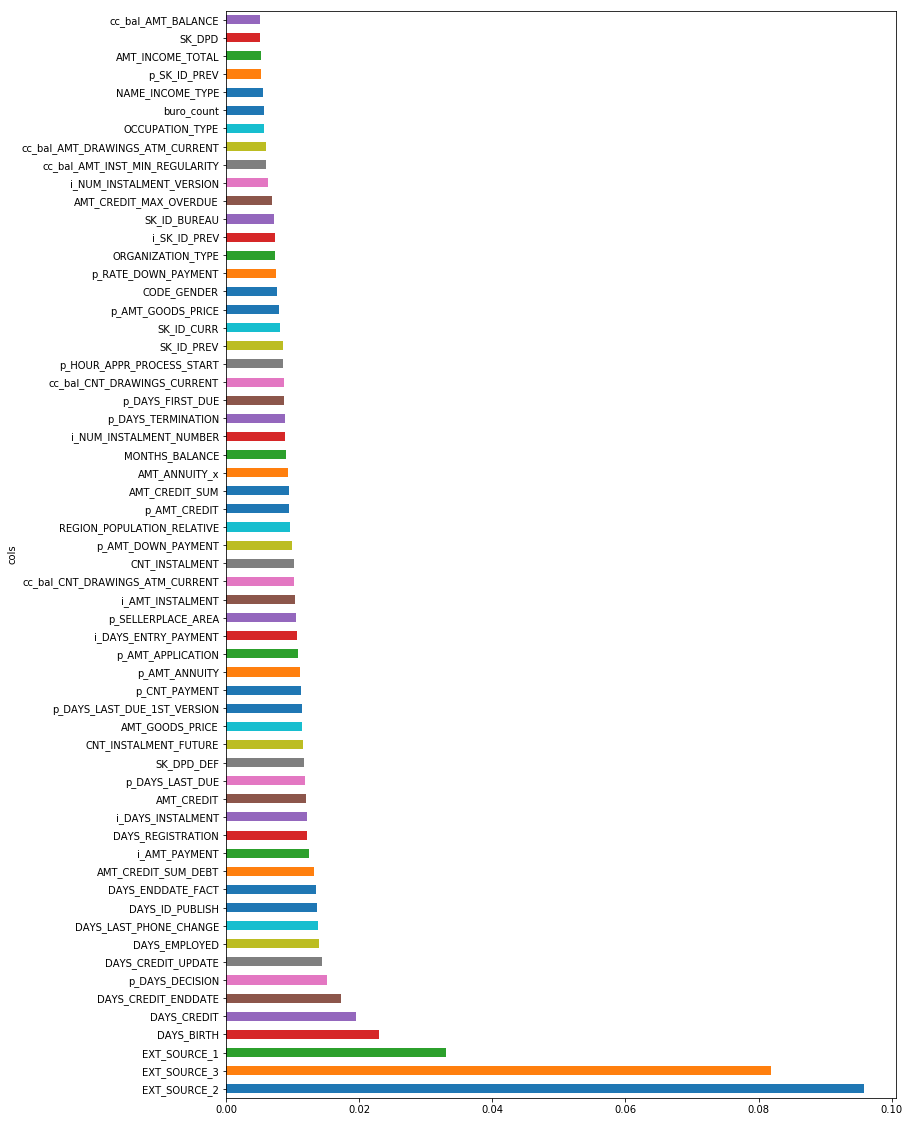

In [142]:
plot_fi(fi[:60])

In [143]:
fi[:30]

,cols,imp
41,EXT_SOURCE_2,0.095776
42,EXT_SOURCE_3,0.081916
40,EXT_SOURCE_1,0.033025
16,DAYS_BIRTH,0.022969
122,DAYS_CREDIT,0.019552
124,DAYS_CREDIT_ENDDATE,0.017255
146,p_DAYS_DECISION,0.015153
132,DAYS_CREDIT_UPDATE,0.014360
17,DAYS_EMPLOYED,0.013972
94,DAYS_LAST_PHONE_CHANGE,0.013866


In [144]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

60

In [145]:
df_keep = data[to_keep].copy()

In [146]:
display_allRows(df_keep.transpose())

,0,1,2,3,4,...,307506,307507,307508,307509,307510
EXT_SOURCE_2,0.262949,0.622246,0.555912,0.650442,0.322738,...,0.681632,0.115992,0.535722,0.514163,0.708569
EXT_SOURCE_3,0.139376,NaN,0.729567,NaN,NaN,...,NaN,NaN,0.218859,0.661024,0.113922
EXT_SOURCE_1,0.083037,0.311267,NaN,NaN,NaN,...,0.14557,NaN,0.744026,NaN,0.73446
DAYS_BIRTH,-9461,-16765,-19046,-19005,-19932,...,-9327,-20775,-14966,-11961,-16856
DAYS_CREDIT,-874,-1400.75,-867,NaN,-1149,...,NaN,NaN,-867.5,-1104,-1089.45
DAYS_CREDIT_ENDDATE,-349,-544.5,-488.5,NaN,-783,...,NaN,NaN,280.5,-859,3231.27
p_DAYS_DECISION,-606,-1305,-815,-272.444,-1222.83,...,-273,-2497,-2380,-299.5,-587.625
DAYS_CREDIT_UPDATE,-499.875,-816,-532,NaN,-783,...,NaN,NaN,-253.25,-401,-531.091
DAYS_EMPLOYED,-637,-1188,-225,-3039,-3038,...,-236,365243,-7921,-4786,-1262
DAYS_LAST_PHONE_CHANGE,-1134,-828,-815,-617,-1106,...,-273,0,-1909,-322,-787


In [147]:
df_keep.shape

(307511, 60)

In [148]:
df, _, nas = proc_df(df_keep)

In [149]:
df.shape

(307511, 108)

In [150]:
X_train, X_valid = split_vals(df, n_trn)

In [151]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 11.3 s, sys: 1.54 s, total: 12.8 s
Wall time: 8.85 s
[0.7648708773674631, 0.7468945494771284, 0.07354753515416534, 0.06515437082880693, 0.06322732071113157]


In [152]:
m = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 13s, sys: 8.91 s, total: 1min 22s
Wall time: 52.6 s
[0.7730915622518362, 0.7528951530623902, 0.0755660465730843, 0.06586626749219837, 0.06560468705387068]


# Interpretation

In [98]:
#Remove redundant features
from scipy.cluster import hierarchy as hc

In [130]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,50))
dendrogram = hc.dendrogram(z,labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


TypeError: '<' not supported between instances of 'str' and 'float'

# Test set

In [153]:
df_app_test = pd.read_csv(f'{PATH}application_test.csv', low_memory=False)

In [163]:
test_data = pd.read_feather('tmp/test_data')
test_data.shape

(48744, 189)

In [164]:
apply_cats(test_data, df_keep)

In [165]:
df_test_fi = test_data[to_keep].copy()

In [166]:
df_test_fi.shape

(48744, 60)

In [167]:
#df, y, nas = proc_df(df_app,'TARGET')

df_test,a,b = proc_df(df_test_fi,na_dict=nas) #passing in na_dict make sure the missing value columns aligns with training set

In [168]:
df_test.shape

(48744, 108)

In [169]:
predict = m.predict(df_test)

In [170]:
predict

array([0.11481, 0.12088, 0.04674, ..., 0.04852, 0.0457 , 0.16747])

In [171]:
df_pred = pd.DataFrame(predict)

In [172]:
df_pred.insert(0,'SK_ID_CURR',df_app_test['SK_ID_CURR'])

In [173]:
df_pred.rename({0:'TARGET'},axis='columns',inplace=True)

In [174]:
df_pred.head()

,SK_ID_CURR,TARGET
0,100001,0.114809
1,100005,0.120876
2,100013,0.046737
3,100028,0.049196
4,100038,0.133846


In [175]:
df_pred.to_feather(f'{PATH}df_pref')

In [176]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM,exist_ok=True)
df_pred.to_csv(f'{SUBM}subm.csv', index = False)
FileLink(f'{SUBM}subm.csv')

/home/paperspace/kaggle/competitions/home-credit-default-risk/data/subm/subm.csv